In [43]:
import sys
dirname = '/Users/muhammaddaffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)
    
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.applications.mixed_integer import (
    MixedIntegerKrigingModel,
)
from smt.surrogate_models import (
    KPLS,
    MixIntKernelType,
    MixHrcKernelType,
)
from sklearn.metrics import mean_squared_error
from smt.applications.explainability_tools import (
    PartialDependenceDisplay, 
    PDFeatureImportanceDisplay, 
    PDFeatureInteractionDisplay,
    ShapFeatureImportanceDisplay,
    ShapDisplay,
    ShapDisplay2,
    individual_shap_values
)

import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


In [2]:
# Objective function
def cantilever_deflection(x):
    norm_inertia_vals = [
        0.0833, 0.139, 0.380, 0.0796,
        0.133, 0.363, 0.0859, 0.136,
        0.360, 0.0922, 0.138, 0.369,
    ]
    
    I = int(x[0])
    L = x[1]
    S = x[2]
    norm_inertia = norm_inertia_vals[I]

    E = 200e9
    P = 50e3

    y = (P * L**3) / (3 * E * S**2 * norm_inertia)

    return y

def cantilever_deflection_vectorized(X):
    y = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        y[i] = cantilever_deflection(X[i, :])
    return y

class GroundTruthModel:
    def predict_values(self, X):
        return cantilever_deflection_vectorized(X)

In [3]:
%%time
"""Problem definition"""
# Design space
ds = DesignSpace([
    # CategoricalVariable([
    #     "type_A", "type_B", "type_C", "type_D", 
    #     "type_E", "type_F", "type_G", "type_H", 
    #     "type_I", "type_J", "type_K", "type_L",
    # ]),
    CategoricalVariable([
        "A", "B", "C", "D", 
        "E", "F", "G", "H", 
        "I", "J", "K", "L",
    ]),
    FloatVariable(10.0, 20.0),
    FloatVariable(1.0, 2.0),
])
categorical_feature_idx = [0]

f_obj = cantilever_deflection

# Create training and testing data
n_data = 250
n_train = int(0.8 * n_data)
n_test = n_data - n_train
xdoe, _ = ds.sample_valid_x(n_data)
y_doe = [f_obj(xdoe[i]) for i in range(len(xdoe))]

x_ref, _ = ds.sample_valid_x(1000)
y_ref = [f_obj(x_ref[i]) for i in range(len(x_ref))]
X_ref = np.array(x_ref)
y_ref = np.array(y_ref)

X_tr, y_tr = xdoe[:n_train, :], y_doe[:n_train]
X_te, y_te = xdoe[n_train:, :], y_doe[n_train:]
y_tr, y_te = np.array(y_tr), np.array(y_te)

# Name of the features
feature_names = [r'$I$', r'$L$', r'$S$']

# create mapping for the categories
categories_map = dict()
inverse_categories_map = dict()
for feature_idx in categorical_feature_idx:
    categories_map[feature_idx] = {
        i: value for i, value in enumerate(ds._design_variables[feature_idx].values)
    }
    inverse_categories_map[feature_idx] = {
        value: i for value, i in enumerate(ds._design_variables[feature_idx].values)
    }

"""Modelling"""
print("Ground truth model")
gtm = GroundTruthModel()
y_pred = gtm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

Ground truth model
RMSE: 0.0000
rRMSE: 0.0000
CPU times: user 9.65 s, sys: 240 ms, total: 9.89 s
Wall time: 9.97 s


In [4]:
sm = MixedIntegerKrigingModel(
    surrogate=KPLS(
        design_space=ds,
        categorical_kernel=MixIntKernelType.HOMO_HSPHERE,
        hierarchical_kernel=MixHrcKernelType.ARC_KERNEL,
        theta0=np.array([4.43799547e-04, 4.39993134e-01, 1.59631650e+00]),
        corr="squar_exp",
        n_start=1,
        cat_kernel_comps=[2],
        n_comp=2,
        print_global=False,
        ),
    )


start_time = time.time()
sm.set_training_values(X_tr, np.array(y_tr))
sm.train()
print("run time (s):", time.time() - start_time)

print("Surrogate model")
y_pred = sm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

run time (s): 23.853132009506226
Surrogate model
RMSE: 0.0001
rRMSE: 0.0497


In [5]:
sys.path.append("/Users/muhammaddaffarobani/Documents/personal_research/smt/reference/shapley-regression-master")
from shapreg import removal, games, shapley

/Users/muhammaddaffarobani/miniconda3/envs/smt_38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
# Make model callable
model_lam = lambda x: sm.predict_values(x)

# Model extension
marginal_extension = removal.MarginalExtension(X_tr[:], model_lam)

In [37]:
tic = time.time()

# Set up game (single prediction)
instance = X_tr[0, :]
game = games.PredictionGame(marginal_extension, instance)
# Run estimator
explanation = shapley.ShapleyRegression(game, batch_size=32, n_samples=5)

toc = time.time()

  0%|          | 0/1 [00:27<?, ?it/s]


In [42]:
pd.Series(X_tr[:, 0]).value_counts()

0.0     21
9.0     20
2.0     20
7.0     18
1.0     18
8.0     18
11.0    17
6.0     17
3.0     14
10.0    14
5.0     13
4.0     10
Name: count, dtype: int64

(array([20., 20., 20., 21., 22., 18., 21., 18., 18., 22.]),
 array([10.03031629, 11.02431437, 12.01831245, 13.01231054, 14.00630862,
        15.00030671, 15.99430479, 16.98830287, 17.98230096, 18.97629904,
        19.97029712]),
 <BarContainer object of 10 artists>)

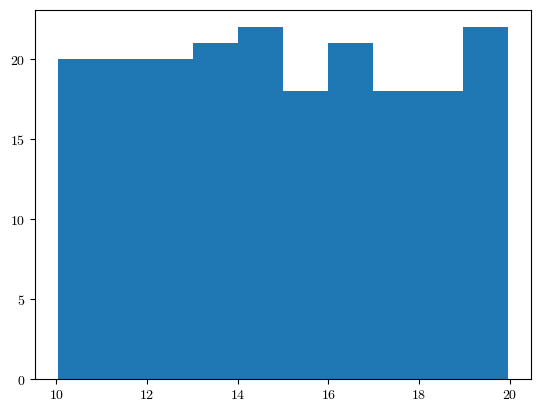

In [44]:
plt.hist(X_tr[:, 1])

In [34]:
isinstance(game, games.CooperativeGame)

True

In [33]:
game.players

3

In [38]:
toc - tic

28.674424171447754

In [32]:
explanation.values

array([[ 8.45125688e-05],
       [-4.73888496e-04],
       [ 6.92244503e-04]])

In [23]:
compare_shap_values = individual_shap_values(instance.reshape(1, -1), sm, X_tr, is_categorical=[True, False, False])

In [25]:
compare_shap_values / 1e-5

array([[ 27.52946601, -11.0962509 ,  65.31320887]])

  0%|          | 0/1 [03:24<?, ?it/s]


TypeError: only size-1 arrays can be converted to Python scalars

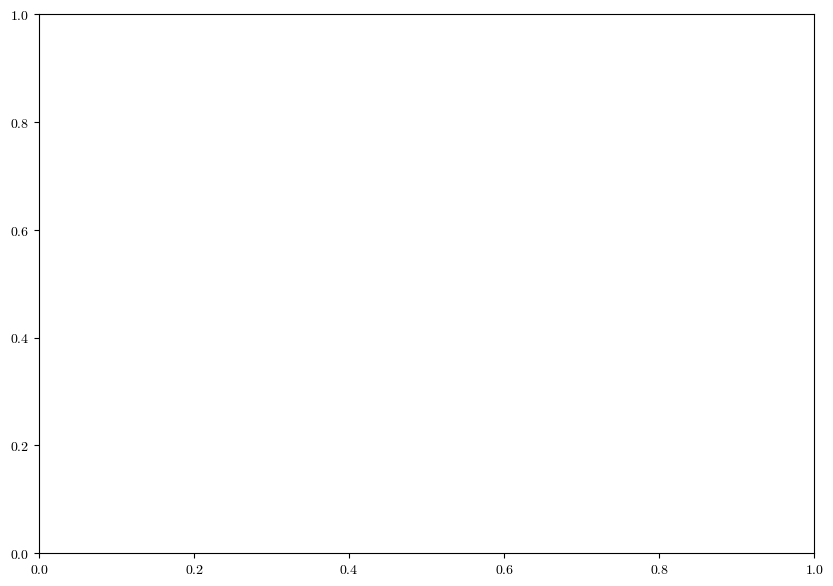

In [14]:
# Plot with 95% confidence intervals
explanation.plot(feature_names, title='SHAP Values', sort_features=False)